In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

# Assignment 2

## 1. Image Stitching 

This problem will walk you through the process of image stitching by detecting and matching corners, and estimating the homography based the matches.

### 1a. Detect Keypoints and Calculate Descriptors (10 points)

Load the sample image pair.

In [2]:
img1 = cv2.imread('data/graff1.png')
img2 = cv2.imread('data/graff2.png')

Since we have implemented the Harris corner detector from scratch in the weekly notebooks, in this problem we will use OpenCV to detect corners and get their descriptors. In the cell below, detect feature points and calculate their descriptors in both images using OpenCV's ORB detector and descriptor.

In [3]:
orb = cv2.ORB_create()

kps1, des1 = orb.detectAndCompute(img1, None)
kps2, des2 = orb.detectAndCompute(img2, None)

Visualize locations of detected features.

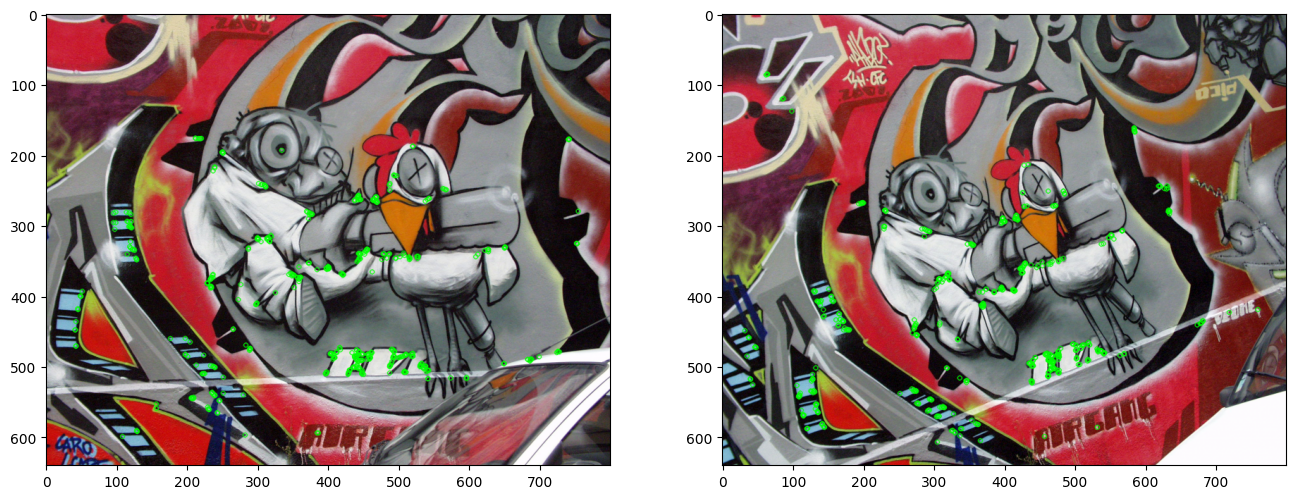

In [4]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

### 1b. Match Keypoints (10 points)

Check out OpenCV's online docs and answer the following question:
- What attributes does each detected keypoint have? Briefly explain what they represent.

In [ ]:
# Type your answer below:
# 
# https://docs.opencv.org/4.x/d2/d29/classcv_1_1KeyPoint.html#a4484e94502486930e94e7391adf9d215
#
# The keypoint class has 
# 1. angle: the orientation of the keypoint measured relative to the image coordinate system clockwise in degrees.(-1 if NA)
# 2. class_id: the object class of the keypoint in case they need to be clustered by object
#  3. octave: the pyramid octave from which the keypoint has been extracted. It is used to keep track of the scale at which the keypoint has been detected.
# 4. pt: the (x,y) position of the keypoint in the image.
# 5. response: the keypoint strength or quality.
# 6. size: the diameter of the meaningful keypoint neighborhood.

- What is the "apparent" size of each descriptor and what data type does it have? (You can easily find the answer by printing the `shape` and `dtype` of a descriptor.) The ORB [paper](https://ieeexplore.ieee.org/document/6126544) says "*we propose a very fast **binary** descriptor based on BRIEF, called ORB*." Based on this, what is the actual length of each binary descriptor?

In [5]:
print(des1.shape)  
print(des1.dtype)  

(500, 32)
uint8


In [ ]:
# Type your answer below:
# 
# I get (500, 32) as the shape of the descriptor, meaning I have 500 descriptors/keypoints with a length of 32 bytes each.
# Also, the dtype of the descriptor is uint8, meaning that the binary lenth of each descriptor is 32 bytes * 8 bits/byte = 256 bits.

- Given two ORB descriptors, how should you measure their distance?

In [ ]:
# Type your answer below:
# 
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
#
# I should use the hamming distance to compare the descriptors since they are binary. "cv.NORM_HAMMING"
# This counts the number of differing bits between two binary strings, for binary descriptors like ORB.

Using `cv2.BFMatcher`, calculate the matching between the two lists of keypoints. Be sure to use the correct distance measurement. Also, set `crossCheck=True` when creating the matcher. After you get the matches, sort them by distance and call `cv2.drawMatches()` to display the 100 closest matches.

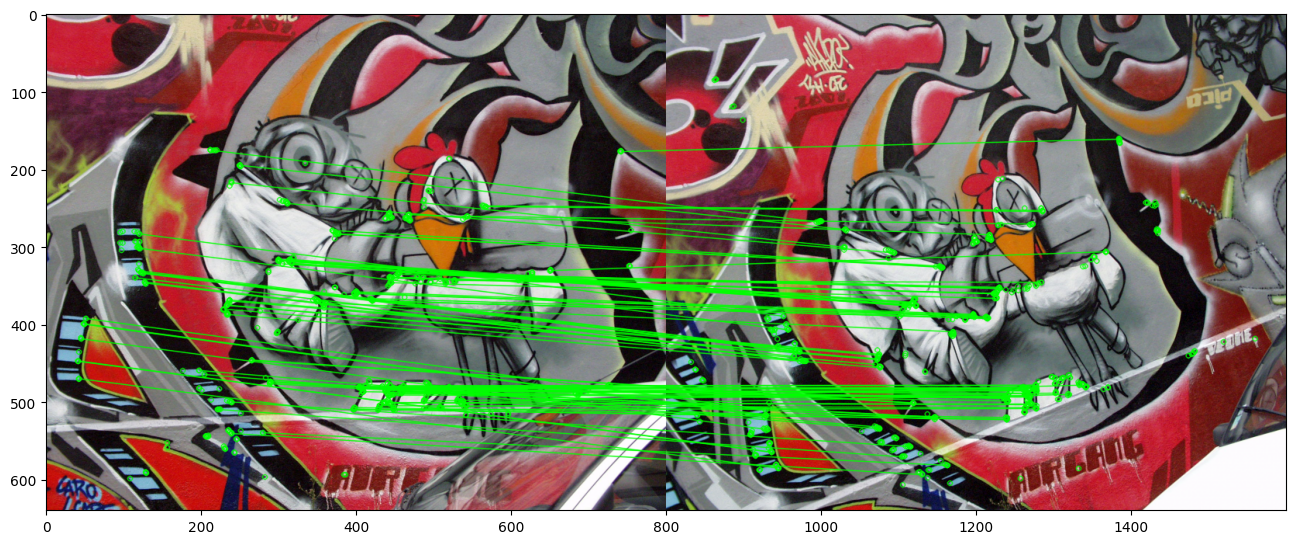

In [6]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
match_img = cv2.drawMatches(img1, kps1, img2, kps2, matches[:100], None,
    matchColor=(0,255,0), singlePointColor=(0,255,0))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

### 1c. Calculate Homography Between Matching Keypoints (20 points)

Implement the following function to calculate the projective transformation that maps a list of (x, y) coordinates `pts1` to the list of matching coordinates `pts2`. The return value is a 3x3 array representing the transformation matrix. You don't need to worry about there being outlier matches between `pts1` and `pts2` here.

You should implement this from from scratch and may **NOT** simply call functions from OpenCV or other libraries to solve this for you. 

In [ ]:
def get_homography(pts1, pts2):
    """Estimate the homography between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective transformation matrix that
          maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."
    # TODO
    return t


# Test the function on sample keypoints.
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]
t = get_homography(pts1, pts2)
print(t)

### 1d. Estimate Homography Between Images Using RANSAC (30 points)

Implement the following function to estimate the homography between two images given keypoints and matches. There may be outliers in the keypoint matches and you should implement the RANSAC algorithm to reject them. You should implement RANSAC from scratch and may **NOT** simply call the corresponding functions in OpenCV or any other existing libraries.

In [ ]:
import random


def estimate_transformation_ransac(kps1, kps2, matches, transform_func,
    n_samples, n_trials, inlier_thresh):
    """Estimate the transformation between two matching lists of keypoints 
    using RANSAC.
    
    Args:
    - kps1: A list of `cv2.KeyPoint` objects.
    - kps2: A list of `cv2.KeyPoint` objects.
    - matches: A list of `cv2.DMatch` objects representing the matches
          between `kps1` and `kps2`.
    - transform_func: Function used to estimate the transformation given
          matching points.
    - n_samples: The number of samples in each RANSAC trial.
    - n_trials: The total number of RANSAC trials.
    - inlier_thresh: The threshold used to determine whether a match is an
          inlier or not.
    
    Returns:
    - transform: The 3x3 transformation matrix that maps kps1 to kps2.
    - mask: A list of Boolean values representing whether the corresponding
          match is an inlier or not.
    """
    # TODO
    return transform, mask

transform, mask = # TODO
print(f"The transformation matrix:\n{transform}.")
print(f"{np.sum(mask)} out of {len(matches)} matches are inliers.")

The following cell warps image 1 based on the estimated homography and displays the overlay of the aligned images.

In [ ]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l,  0))
    r = np.max((r, w2))
    t = np.min((t,  0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    # Warp input images and overlay them.
    warped_img1 = cv2.warpPerspective(img1, shift @ transform, (w, h))
    warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    return overlayed_img


stitched_img = stitch_images(img1, img2, transform)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()

## 2. Disparity Map (30 points)

In this problem you will find dense correspondences between the stereo image pair below and calculate the disparity map. This will be done by doing template matching between image windows.

In [ ]:
img1 = cv2.imread('data/left.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY) / 255.

img2 = cv2.imread('data/right.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY) / 255.

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img1, cmap='gray')
ax1.set_title('left')
ax2.imshow(img2, cmap='gray')
ax2.set_title('right')
plt.show()

In the cell below, implement a system to calculate the disparity map and visualize the results. You can assume that the camera angle of the images are already rectified, so the epipolar lines are all horizontal. Use SSD as the similarity measure between windows. Set the window size to `7` and the maximum disparity value to `40`.

Recall from the lectures we covered a naive implementation and a more efficient one. Please implement the efficient version.

In addition, operations on image arrays (such as shifting an image or comparing two image arrays) should be implemented in the vectorized form for more efficiency, instead of requiring two for-loops to loop through pixels one by one.

In [ ]:
from scipy.signal import convolve2d


assert img1.shape == img2.shape
h, w = img1.shape

dmin, dmax = 0, 40  # disparity search range
s = 7  # windows size

# TODO

plt.imshow(disp, cmap='gray')
plt.colorbar()
plt.show()